The AB test is a randomized experiment that is used by most large companies to evaluate the launch of new functionality. Various difficulties may arise in the analysis and conduct of the experiment. Several typical problematic cases from real life are given in this dataset and analysis.

### Content
1. [Loading and processing data](#Loading)
2. [Statistical Analysis](#Statistical)
3. [Conclusions](#Conclusions)

### Loading and processing data <a name="Loading"/>

Let's import the necessary libraries and load the data

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import shapiro

In [2]:
# TODO : import the dataset

from google.colab import files


uploaded = files.upload()

df = pd.read_csv("AB_Test_Results.csv")

Saving AB_Test_Results.csv to AB_Test_Results.csv


In [3]:
# TODO : take a quick look at the data

print(df.shape)
print(df.columns)
print(df.info())
print(df.head())

(10000, 3)
Index(['USER_ID', 'VARIANT_NAME', 'REVENUE'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB
None
   USER_ID VARIANT_NAME  REVENUE
0      737      variant      0.0
1     2423      control      0.0
2     9411      control      0.0
3     7311      control      0.0
4     6174      variant      0.0


Let's see if there are users who have two A/B test groups


In [10]:
# TODO : Look at the distribution of the number of unique groups for each user
user_group = df.groupby('USER_ID')['VARIANT_NAME'].nunique()
user_group.value_counts()

#user_group.hist(bins=15)
#plt.show()

,count
VARIANT_NAME,
1,4783
2,1541


In [11]:
# TODO : Look at the distribution of the number of unique groups for each user in relative terms
user_group.value_counts(normalize=True).sort_index()

,proportion
VARIANT_NAME,
1,0.756325
2,0.243675


What can you observe ? Should we exclude these users ? Why ?

#Analysis: 4783 users are only in one group, while another 1541 are found in two. Relatively, that means that 75.6% of users represent unique, good values and approximately 24/25% will need to be removed.

In [26]:
# TODO : users have 1 A/B test group ?

user_group_one=user_group[user_group==1]
user_group_two=user_group[user_group==2]

print(f"There are {len(user_group_one)} users with 1 A/B test group and another {len(user_group_two)} users that will need to be removed.")
# TODO : Take only these users

df_new = df[df['USER_ID'].isin(user_group_one.index)].copy()


There are 4783 users with 1 A/B test group and another 1541 users that will need to be removed.
Number of users in df_new: 4783
Should match: 4783


In [28]:
# TODO : Leave only records with users with the 1st ab test group

print("Number of users in df_new:", df_new['USER_ID'].nunique())


# TODO : Check that the number of users matches what it was before the exception
print(f"Confirm it matches: {len(user_group_one)}")

Number of users in df_new: 4783
Confirm it matches: 4783


Let's see how the data is distributed

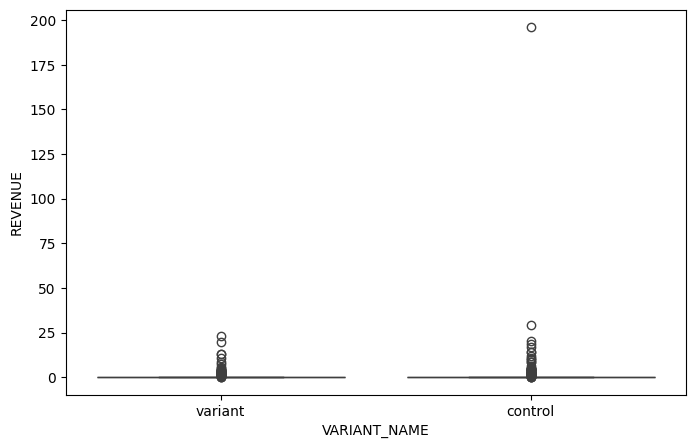

In [34]:
# TODO : Check how the data is distributed using a box plot
plt.figure(figsize=(8,5))

sns.boxplot(data=df_new,x='VARIANT_NAME', y='REVENUE')
plt.show()

It can be seen that there is a strong outlier in the data - we will find it by sorting these revenue values in descending order

In [40]:
# TODO : Sort these revenue values in descending order
df_new.sort_values(by='REVENUE', ascending=False, inplace=True)

print(df_new.head(30))
print(df_new.shape)

      USER_ID VARIANT_NAME  REVENUE
1437     3342      control   196.01
8168     2166      control    29.32
2482     7356      variant    23.04
6412     1053      control    20.07
5217     3684      variant    19.47
5530      282      control    18.56
758      4445      control    17.05
4031     2059      control    14.24
9019     1973      control    14.07
4561     4966      variant    12.99
5212     6294      variant    12.99
1468     1773      control    11.98
2726     3326      variant    10.82
628      6365      control    10.63
6483     2212      control     9.99
333      8020      control     9.91
2702     8886      variant     8.70
7568     2928      control     8.66
3740     1788      control     8.66
7151     6065      variant     7.27
8129     5900      control     6.35
8301     3797      variant     5.98
4374     9520      variant     5.08
8130     4918      control     4.98
2759     7103      control     4.95
1148     5350      control     4.87
6451     1339      variant  

In [42]:
# TODO : See if user 3342 had other events with a strong outlier

df_new[df_new['USER_ID']== 3342].sort_values('REVENUE',ascending=False)

,USER_ID,VARIANT_NAME,REVENUE
1437,3342,control,196.01


We see that there is only one outlier - in conditions of limited information, we will remove this entry and look at the distribution of data again

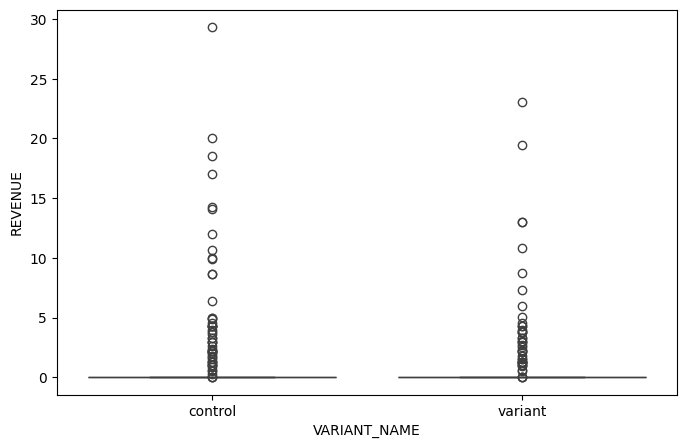

In [44]:
# TODO : We see that there is only one outlier - in conditions of limited information, remove this entry and visualize the distribution of data again.


df_new = df_new[df_new['REVENUE'] != 196.01].copy()

plt.figure(figsize=(8,5))

sns.boxplot(data=df_new,x='VARIANT_NAME', y='REVENUE')
plt.show()


What can you say about the users and their purchases ?

##Analysis: The majority of users don't buy anything. Those who do procure only a little. A small numer of users buy between 15-20, and one outlier buys 30!

In [50]:
# TODO : Check if there are users who have records with zero and positive revenue

positive = df_new[df_new['REVENUE'] > 0]

positive_users = set(positive['USER_ID'])
print(len(positive_users))

net_zero = df_new[df_new['REVENUE'] == 0]

net_zero_users = set(net_zero['USER_ID'])
print(len(net_zero_users))

user_in_both = positive_users.intersection(net_zero_users)
print(len(user_in_both))

95
4724
37


Can a user have records with both zero and positive revenue ?

##Analysis: Yes, 37 users visited and bought nothing at one point and then bought something at another point.

Let's make the assumption that the records are user visits to the service, and the experimental unit is users.


In [55]:
# TODO : Group the data for each user and sum the revenue for each to get one record per user

user_data = df_new.groupby('USER_ID').agg({'REVENUE': 'sum', 'VARIANT_NAME': 'first'}).reset_index()

user_data.shape

(4782, 3)

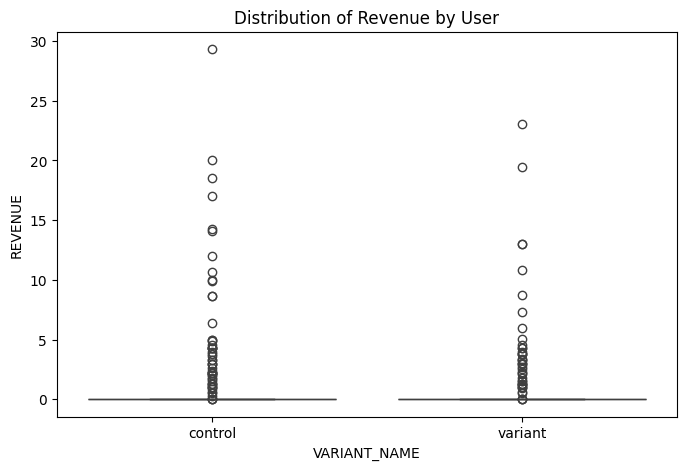

In [56]:
# TODO : Visualize the resulting distribution of the data again.

plt.figure(figsize=(8,5))

sns.boxplot(data=user_data,x='VARIANT_NAME', y='REVENUE')
plt.title('Distribution of Revenue by User')
plt.show()

It should be noted that during the transformation, the quantiles in the test group increased

It can be seen that in the test group, almost all quantile statistics, except for the minimum, are at a slightly lower level.

Let's look at various statistics in the context of AB test groups for all users

In [57]:
df_new.shape #confirming the chart is different (it looks identical!)
user_data.shape
user_data[user_data['REVENUE'] > 0].head()

,USER_ID,REVENUE,VARIANT_NAME
27,56,2.99,variant
61,124,1.25,control
83,169,4.33,control
137,282,18.56,control
209,443,3.75,variant


In [60]:
from seaborn._core.typing import OrderSpec
# TODO : get metrics by groups
control = user_data[user_data['VARIANT_NAME'] == 'control']
variant = user_data[user_data['VARIANT_NAME'] == 'variant']

control_users = len(control)
variant_users = len(variant)

#total revenue
control_users_revenue = control['REVENUE'].sum()
variant_users_revenue = variant['REVENUE'].sum()

#average check / user
control_users_average_check = control[control['REVENUE']>0]['REVENUE'].mean()
variant_users_average_check = variant[variant['REVENUE']>0]['REVENUE'].mean()

#number of orders / user
control_users_orders = len(control[control['REVENUE']>0]) / len(control)
variant_users_orders = len(variant[variant['REVENUE']>0]) / len(variant)

summary = pd.DataFrame({
    'Variable': ['Total Revenue', 'Average Check Per User', 'Number of Orders Per User'],
    'Control': [control_users_revenue, control_users_average_check, control_users_orders],
    'Variant': [variant_users_revenue, variant_users_average_check, variant_users_orders]
})

print(summary)


# TODO : create two additional metrics to see relative changes

revenue_changes = (variant_users_revenue - control_users_revenue) / control_users_revenue

check_changes = (variant_users_average_check - control_users_average_check) / control_users_average_check

order_changes = (variant_users_orders - control_users_orders) / control_users_orders


# TODO : add them to the rest of the metrics in a separate group


relative_summary = pd.DataFrame({
    'Variable': ['Total Revenue Relevant Change', 'Average Check Per User Relevant Change', 'Number of Orders Per User Relevant Change'],
    'Relevant Change %': [revenue_changes * 100, check_changes *100, order_changes *100]
})

print(relative_summary)

                    Variable     Control     Variant
0              Total Revenue  274.550000  179.320000
1     Average Check Per User    5.180189    4.269524
2  Number of Orders Per User    0.022185    0.017551
                                    Variable  Relevant Change %
0              Total Revenue Relevant Change         -34.685850
1     Average Check Per User Relevant Change         -17.579763
2  Number of Orders Per User Relevant Change         -20.887179


What can you see in the test group about the total amount of revenue, the average check per user, and the number of orders per user slightly increased ?

##Analysis: Everything in the variant group decreased


Let's also see how paying users behave :

In [62]:
# TODO : get metrics by groups

paying_control = control[control['REVENUE'] > 0]
paying_variant = variant[variant['REVENUE'] > 0]

paying_control_users = len(paying_control)
paying_variant_users = len(paying_variant)

#total revenue
paying_control_users_revenue = paying_control['REVENUE'].sum()
paying_variant_users_revenue = paying_variant['REVENUE'].sum()

#average check / user
paying_control_users_average_check = paying_control['REVENUE'].mean()
paying_variant_users_average_check = paying_variant['REVENUE'].mean()

#number of orders / user
paying_control_users_orders = paying_control_users / control_users
paying_variant_users_orders = paying_variant_users / variant_users

summary = pd.DataFrame({
    'Variable': ['Total Revenue', 'Average Check Per Paying User', 'Share of Paying User'],
    'Control': [paying_control_users_revenue, paying_control_users_average_check, paying_control_users_orders],
    'Variant': [paying_variant_users_revenue, paying_variant_users_average_check, paying_variant_users_orders]
})

print(summary)

# TODO : create two additional metrics to see relative changes
revenue_changes = (paying_variant_users_revenue - paying_control_users_revenue) / paying_control_users_revenue *100

check_changes = (paying_variant_users_average_check - paying_control_users_average_check) / paying_control_users_average_check *100

order_changes = (paying_variant_users_orders - paying_control_users_orders) / paying_control_users_orders * 100


# TODO : add them to the rest of the metrics in a separate group

relative_summary_two = pd.DataFrame({
    'Variable': ['Change in Total Revenue (PAID)', 'Change in Average Check (PAID)', 'Change in Number of Orders (PAID)'],
    'Relevant Change %': [revenue_changes, check_changes, order_changes]
})

print(relative_summary_two)

                        Variable     Control     Variant
0                  Total Revenue  274.550000  179.320000
1  Average Check Per Paying User    5.180189    4.269524
2           Share of Paying User    0.022185    0.017551
                            Variable  Relevant Change %
0     Change in Total Revenue (PAID)         -34.685850
1     Change in Average Check (PAID)         -17.579763
2  Change in Number of Orders (PAID)         -20.887179


Let's look at the distributions of all and only paying users

/tmp/ipython-input-4234681403.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_new.loc[df_new['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
/tmp/ipython-input-4234681403.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_new.loc[df_new['VARIANT_NAME'] == 'var

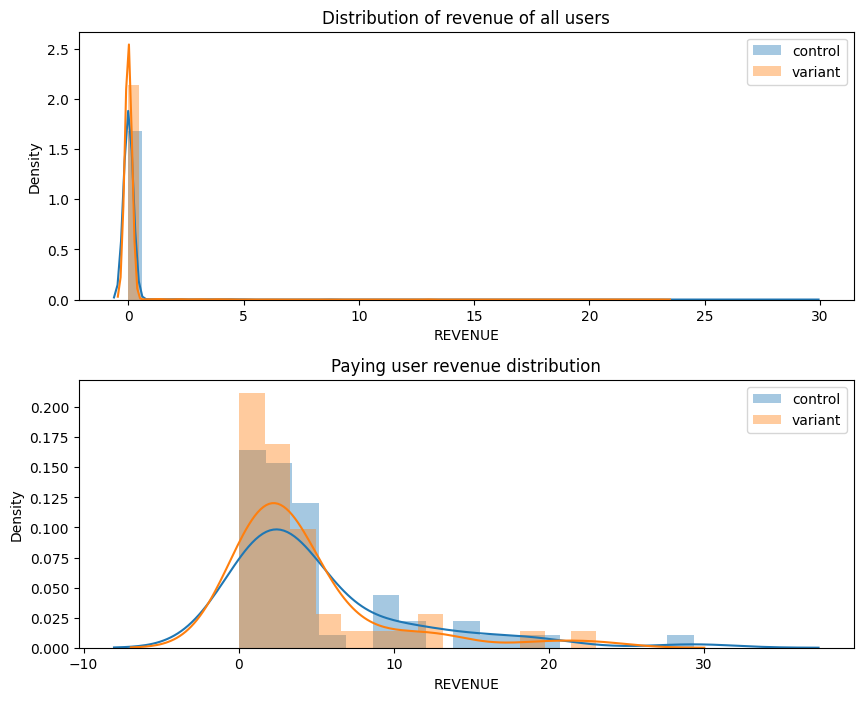

In [64]:
f, axes = plt.subplots(2, figsize=(10,8))
# build graphs of distributions of all users
sns.distplot(df_new.loc[df_new['VARIANT_NAME'] == 'control', 'REVENUE'], ax = axes[0], label='control')
sns.distplot(df_new.loc[df_new['VARIANT_NAME'] == 'variant', 'REVENUE'], ax = axes[0], label='variant')
axes[0].set_title('Distribution of revenue of all users')
axes[0].legend()

# build graphs of distributions of paying users
sns.distplot(df_new.loc[(df_new['VARIANT_NAME'] == 'control') & (df_new['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='control' )
sns.distplot(df_new.loc[(df_new['VARIANT_NAME'] == 'variant') & (df_new['REVENUE'] > 0), 'REVENUE'], ax = axes[1], label='variant' )
axes[1].set_title('Paying user revenue distribution')
axes[1].legend()
plt.subplots_adjust(hspace = 0.3)

### Statistical Analysis <a name="Statistical"/>

#### Checking if the distribution is normal

Based on their previous graph, we see that the data is not normally distributed.

In [65]:
stat_all, p_all = shapiro(df_new['REVENUE'])
print(stat_all, p_all)

# TODO : Use the Shapiro-Wilk criterion to confirm it



0.05623680516028973 1.0192650761177012e-99


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6069.
  res = hypotest_fun_out(*samples, **kwds)


Is the null hypothesis about the normal distribution of the data rejected ?

##Analysis: Yes, we rejet the null hypothesis because the p_all result is 1.019E-99, which is much, much, much smaller than 0.05.

#### Mann-Whitney test

Let's check the value of the statistics of the Mann-Whitney test. Some sources have a limitation of applicability in case of duplicate data. There are a lot of repetitions in our sample, and especially a lot of zero values, so in this case we need to be careful about this criterion.

In [67]:
(df_new['REVENUE'] == 0).value_counts()  #modfified to df_new since i filtered already and copied

##Analysis: there are almost 6000 users that bought nothing and about 100 that bought something.

,count
REVENUE,
True,5973
False,96


In [68]:
# TODO : Check on the data of all users the value of the statistics of the Mann-Whitney test

control_all = df_new[df_new['VARIANT_NAME'] == 'control']['REVENUE']
variant_all = df_new[df_new['VARIANT_NAME'] == 'variant']['REVENUE']

u_statistic, p_value = mannwhitneyu(control_all, variant_all)
print(f"Mann-Whitney U Test: U={u_statistic}, p-value={p_value}")

##No meaningful difference

Mann-Whitney U Test: U=4619788.0, p-value=0.2859842308619548


In [70]:
# TODO : Check on the data of only the users that pay, the value of the statistics of the Mann-Whitney test


control_p = df_new[(df_new['VARIANT_NAME'] == 'control') & df_new['REVENUE'] > 0] ['REVENUE']
variant_p = df_new[(df_new['VARIANT_NAME'] == 'variant') & df_new['REVENUE'] > 0] ['REVENUE']

u_statistic, p_value = mannwhitneyu(control_p, variant_p)
print(f"Mann-Whitney U Test: U={u_statistic}, p-value={p_value}")

#same probably because paying users aren't large enough to make a difference

Mann-Whitney U Test: U=1249.0, p-value=0.4218148352342157


#### Bootstrap

In order to get more complete information about the differences between the average values of the ab test groups, we will use bootstap.

Let's create a function to get back samples and get a confidence interval, and then look at the sample statistics

In [71]:
def get_bootstrap_samples(data, n_samples=1000):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha=0.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [72]:
# TODO : Generate samples for all users
control_all = df_new[df_new['VARIANT_NAME'] == 'control']['REVENUE'].values
variant_all = df_new[df_new['VARIANT_NAME'] == 'variant']['REVENUE'].values

control_samples = get_bootstrap_samples(control_all,1000)
variant_samples = get_bootstrap_samples(variant_all,1000)


In [73]:
# TODO : Generate samples for only paying users

control_p = df_new[(df_new['VARIANT_NAME'] == 'control') & df_new['REVENUE'] > 0] ['REVENUE'].values
variant_p = df_new[(df_new['VARIANT_NAME'] == 'variant') & df_new['REVENUE'] > 0] ['REVENUE'].values
control_p_samples = get_bootstrap_samples(control_p,1000)
variant_p_samples = get_bootstrap_samples(variant_p,1000)

Let's look at the distribution of means in the ab test groups

/tmp/ipython-input-2403277890.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_samples, axis=1), shade=True, label='control')
/tmp/ipython-input-2403277890.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_samples, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for all users')

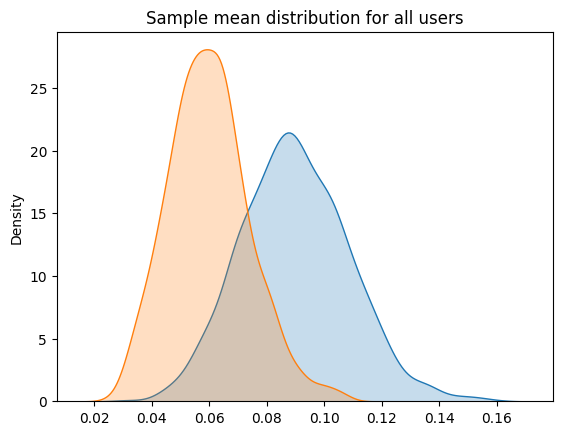

In [75]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_samples, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_samples, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for all users')

/tmp/ipython-input-57925828.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(control_p_samples, axis=1), shade=True, label='control')
/tmp/ipython-input-57925828.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.mean(variant_p_samples, axis=1), shade=True, label='variant')


Text(0.5, 1.0, 'Sample mean distribution for paying users')

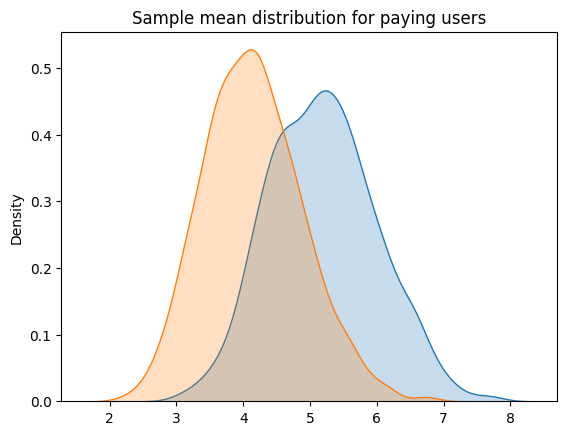

In [76]:
f, ax = plt.subplots()
# plt.figure(figsize=(20,5))
sns.kdeplot(np.mean(control_p_samples, axis=1), shade=True, label='control')
sns.kdeplot(np.mean(variant_p_samples, axis=1), shade=True, label='variant')
plt.title('Sample mean distribution for paying users')

Do you see any difference ? What about the confidence intervals ? Conclude.
##Analysis: NOt much of a difference, the second one shifts more to the right suggesting that users in both groups (the paying ones) spend a similar amount in revenue. No significant change in user behavior.
Let's evaluate the difference between the groups: look at the distribution of the mean difference and build confidence intervals for it. To do this, we will create a function for visualization

In [77]:
def plot_distribution_and_stat_intervals(variant, control, title, alpha=0.05):
    """ Plot the distribution of the mean difference and return the confidence intervals """
    f, ax = plt.subplots()
    # get data for coloring confidence intervals
    points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()
    x = points[0]
    y = points[1]
    ymin, ymax = plt.ylim()
    # highlight the zero value and the bounds of the confidence interval
    plt.vlines(0, 0, ymax, label='0', color='gray')
    plt.vlines(stat_intervals(variant - control, alpha)[0], 0, ymax, linestyles="dashed")
    plt.vlines(stat_intervals(variant - control, alpha)[1], 0, ymax, linestyles="dashed")
    # color the confidence interval and zones outside it
    plt.fill_between(x,y,
                     where = (x >= stat_intervals(variant - control, alpha)[1]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = (x <= stat_intervals(variant - control, alpha)[0]),
                     color='gainsboro')
    plt.fill_between(x,y,
                     where = ((x >= stat_intervals(variant - control, alpha)[0])
                              & (x <= stat_intervals(variant - control, alpha)[1])),
                     color='red',
                     label = '95% confidence interval')
    plt.title(f'Distribution of difference between means (variant - control) {title}; {100*(1-alpha)}% Confidence interval for difference of means: {stat_intervals(variant - control, alpha)}')
    plt.legend(prop={'size':13})
    # return confidence interval data
    return stat_intervals(variant - control)

Let's build a graph of the distribution of the difference in the means and get a confidence interval

For all users

/tmp/ipython-input-4111737823.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()


IndexError: list index out of range

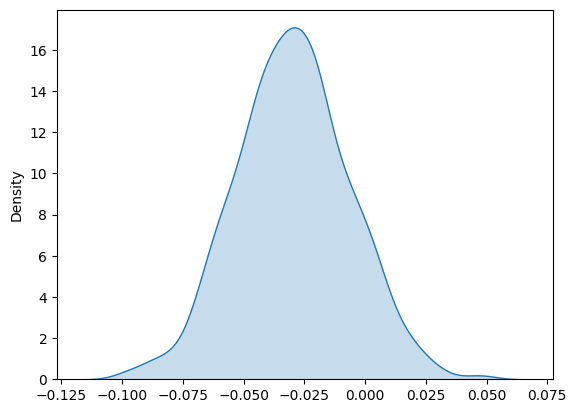

In [80]:
plot_distribution_and_stat_intervals(np.mean(variant_samples, axis=1),
                                     np.mean(control_samples, axis=1),
                                     title='all users')

/tmp/ipython-input-4111737823.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  points = sns.kdeplot(variant - control, shade=True).get_lines()[0].get_data()


IndexError: list index out of range

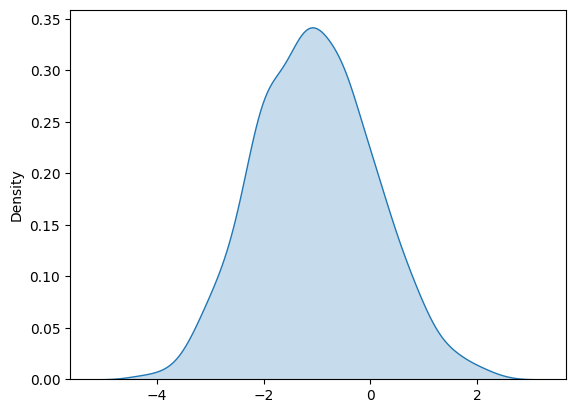

In [81]:
plot_distribution_and_stat_intervals(np.mean(variant_p_samples, axis=1),
                                     np.mean(control_p_samples, axis=1),
                                     title='paying users')

What can you observe ? Conclude about the statistical change in average revenue between A/B test groups.



In [ ]:
##Analysis: Variant performs worse. Result not stastitically significant.